# **Project_06_Building LSTM Model: Lyrics Generator With Keras**

## **0. 평가문항	상세기준**
---

1. 가사 텍스트 생성 모델이 정상적으로 동작하는가?

  - 텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?
2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?

  - 특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?
3. 텍스트 생성모델이 안정적으로 학습되었는가?

  - 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?


## **1. 데이터 불러오기 및 확인**
---

### **1-1. 라이브러리, 클래스, 함수 불러오기**

In [ ]:
############################################## 라이브러리 불러오기 #####################################################
# !pip install pmdarima
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.5f}'.format #지수표현식말고 실수로 표현
import platform
import random
import warnings
import statsmodels
import math
import tensorflow as tf
from pathlib import Path
import glob
import re
warnings.filterwarnings(action = "ignore")
# 시각화

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

# 모델 성능 평가 지표, 학습데이터 분리 
from sklearn.model_selection import train_test_split

# 구글드라이브 
from google.colab import drive
import os


plt.rcParams['axes.unicode_minus'] = False 
# fm._rebuild()



### **1-2. 데이터 불러오기**

In [ ]:
############################## 데이터 경로지정  ##############################
# 구글드라이브 
from google.colab import drive
import os
root = "/content/drive"
drive.mount(root, force_remount=True)

googledrive_path = os.path.join(root,"MyDrive/github/ML-DL-Project")
project_dir = "Project_06_Building LSTM Model: Lyrics Generator"
data_path = os.path.join(root,googledrive_path,project_dir,"src/data")
print('data path: ',data_path)

Mounted at /content/drive
data path:  /content/drive/MyDrive/github/ML-DL-Project/Project_06_Building LSTM Model: Lyrics Generator/src/data


In [ ]:
############################## 데이터 불러오는 함수 정의  ##############################

def load_text_data(path = data_path):
  # 1) glob 를 활용하여 모든 txt 파일을 읽어온 후,
  text_file_list = glob.glob(data_path+'/*.txt')
  # 2) 라인 단위로 끊어서 읽어온다.
  corpus_and_idx = [(idx, open(txt_file, "r").read().splitlines()) for idx, txt_file in enumerate(text_file_list) ]
  raw_corpus = [open(txt_file, "r").read().splitlines() for txt_file in text_file_list ]
  raw_corpus = sum(raw_corpus, []) # 중첩리스트 flatten하게 만들기 
  return raw_corpus , corpus_and_idx


여기서 corpus 란 사전적인 의미로는 말뭉치인데, 자연어처리에서는 모델을 학습시키기 위한 데이터를 의미한다. 본 프로젝트에서 사용하는 데이터는 여러개의 텍스트파일로 나눠져있는데, 각 텍스트파일에는 노래 한곡에 해당하는 가사가 적혀있다. 

In [ ]:

############################## 데이터 불러오기& 각 파일마다 랜덤으로 네줄씩 출력하기 ##############################

raw_corpus, corpus_and_idx = load_text_data(data_path)

# print("{:=^75}".format(""))
print("전체 텍스트파일 갯수:", len(corpus_and_idx),"\n")
print("{:=^75} ".format(" [데이터 일부 확인] "))
for idx, corpus in np.array(corpus_and_idx):
  print(f"[idx: {idx}]")
  words_counts_per_row = dict([(row,len(row.split())) for row in corpus ])
  max_key = max(words_counts_per_row, key = words_counts_per_row.get)
  min_key = min(words_counts_per_row, key = words_counts_per_row.get)
  print(f"* 단어수가 가장 많은 줄: '{max_key}' (공백제외 {words_counts_per_row[max_key]} 단어)")
  print(f"* 단어수가 가장 적은 줄: '{min_key}' (공백제외 {words_counts_per_row[min_key]} 단어)")
  print("* 랜덤으로 5줄 출력")
  [print("   - "+row) for row in random.sample(corpus, 5)]
  print("{:-^75}".format(""))


전체 텍스트파일 갯수: 49 

=============================== [데이터 일부 확인] =============================== 
[idx: 0]
* 단어수가 가장 많은 줄: 'But I know a change is gonna come, oh yes it will I go to the movie and I go downtown somebody keep telling me don't hang around' (공백제외 28 단어)
* 단어수가 가장 적은 줄: 'Oh' (공백제외 1 단어)
* 랜덤으로 5줄 출력
   - Wash me in the water
   - Love and happiness
   - Call me What a beautiful time we had together,
   - What I told you, told you, that entire time you're gonna pay
   - How can you stop the rain from falling down?
---------------------------------------------------------------------------
[idx: 1]
* 단어수가 가장 많은 줄: 'JW: Another dirty money, heaven sent honey turning on a dime [CHORUS] Its just another way to Hey Its just another way to Youve got to. JW: Another girl with her finger on the world singing do what you wanna hear' (공백제외 41 단어)
* 단어수가 가장 적은 줄: 'Ooh' (공백제외 1 단어)
* 랜덤으로 5줄 출력
   - New York, New York, New York
   - And I'd call you back for more If I was your woman
   - I

> 각 텍스트파일마다 랜덤으로 4줄을 추출해서 출력해본 결과, 대부분의 파일은 문장단위로 한줄씩 구성한것으로 추측할 수 있다. 하지만 몇몇 파일은 문단 단위로 
일부 데이터를 살펴보는것만으로 대략적으로 어떤 처리를 해야할지 가늠이 가능한데, 이는 아래에서 확인할 수 있다.  
- 아예 공백으로만 이루어진 줄이 존재한다. 이런 데이터는 제거해야한다.
- 노래가사의 특성상 한문장안에 같은 단어가 연속적으로 여러번 반복되는 경우가 있는데, 이에 해당하는 경우에는 해당 단어를 삭제하던가하는 처리를 해주면 좋을것같다. 
  - Oh, oh, oh, oh,
  - I'm I'm 
  - Let's, let's 
- 한줄안에 괄호가 들어가있는 경우가 있는데 이는 피쳐링으로 예상되는데, 괄호안에 들어가는 패턴도 다양하다. 아래에서 확인해보도록 하겠다.
  - 한줄안에 존재하는 단어와 비슷하거나 같은 단어 (라임을 맞추기위함으로 보임, 주로 마지막 단어와 비슷한 단어인 경우가 많음)
  - 불완전한 문장
  - 완전한 문장   
  이렇게 피쳐링으로 예상되는 경우는 괄호를 하나의 문장으로보고 나눠준후, 또 2차로 단어 1개짜리 제거 or 불완전한 문장 처리 하는식으로 진행을 하면 좋을것같다. 
- 문장의 마지막이 . 로 되어있지않다. (문장의 끝이 불분명)


### **1-3. 데이터 탐색 및 전처리**

min words per row:  0
max words per row:  308


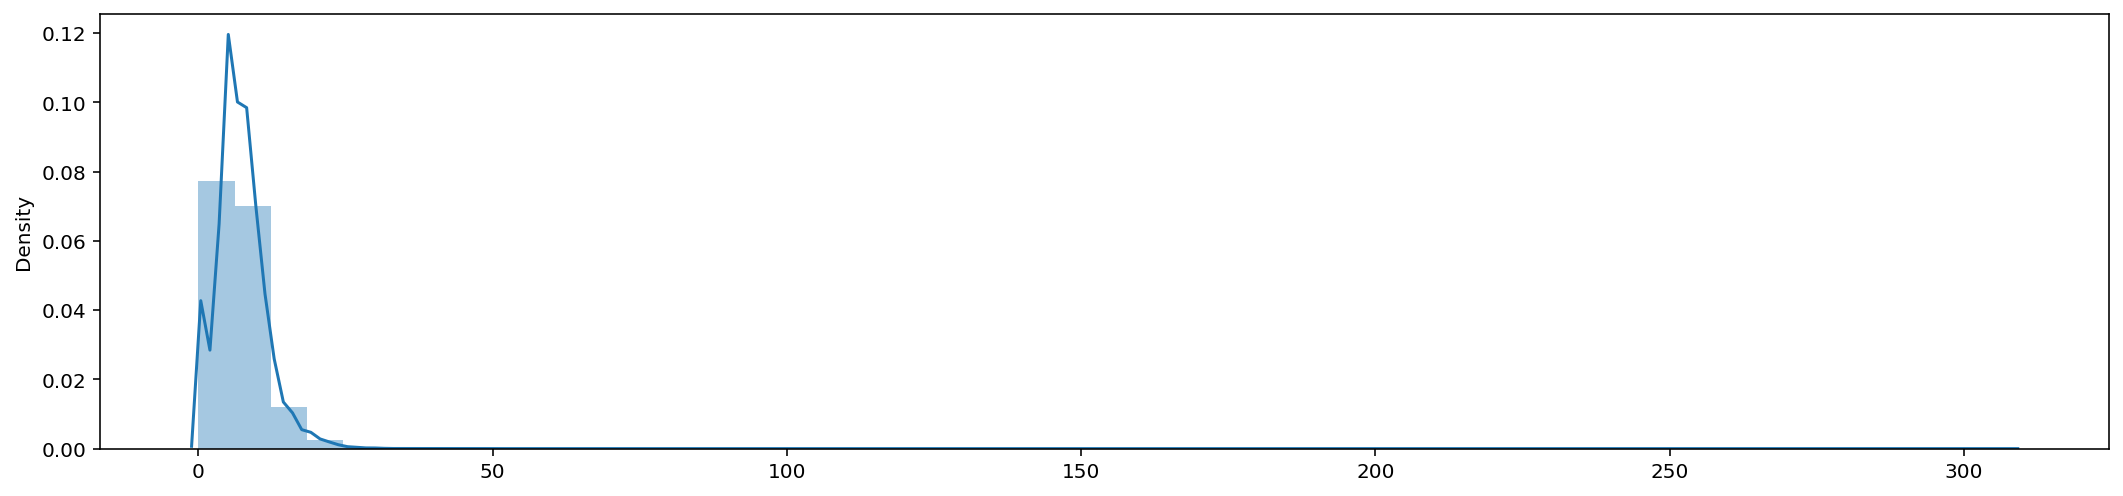

In [ ]:
############################## 1차 문장 필터링 문장내 단어의 갯수 파악 : 단어는 공백기준으로 판단 ##############################
# 문장의 단어갯수가 2개 미만이면 삭제처리? 
# 문장들의 단어갯수 분포 히스토그램을 보면 대부분 몇글자로 이루어져있는지 알 수 있음
words_count = [len(row.split()) for row in raw_corpus  ]


# 전체 문장의 단어갯수 중에서 제일 작은 수 
print("min words per row: ", min(words_count) ) 
# 전체 문장의 단어갯수 중에서 제일 큰 수 
print("max words per row: ", max(words_count) ) 
# 시각화
plt.figure(figsize=(18,4))
sns.distplot(words_count)
plt.show()


문장의 단어 갯수가 대부분 1개~30개 사이에 분포한것을 볼 수 있는데, 단어수가 2개 미만인 것 들은 문장이라고 할 수 없다. 또한 30-40개 이상은 여러 문장이 한줄안에 기입된것으로 예상할 수 있다. 

min words per sentence:  0
max words per sentence:  308


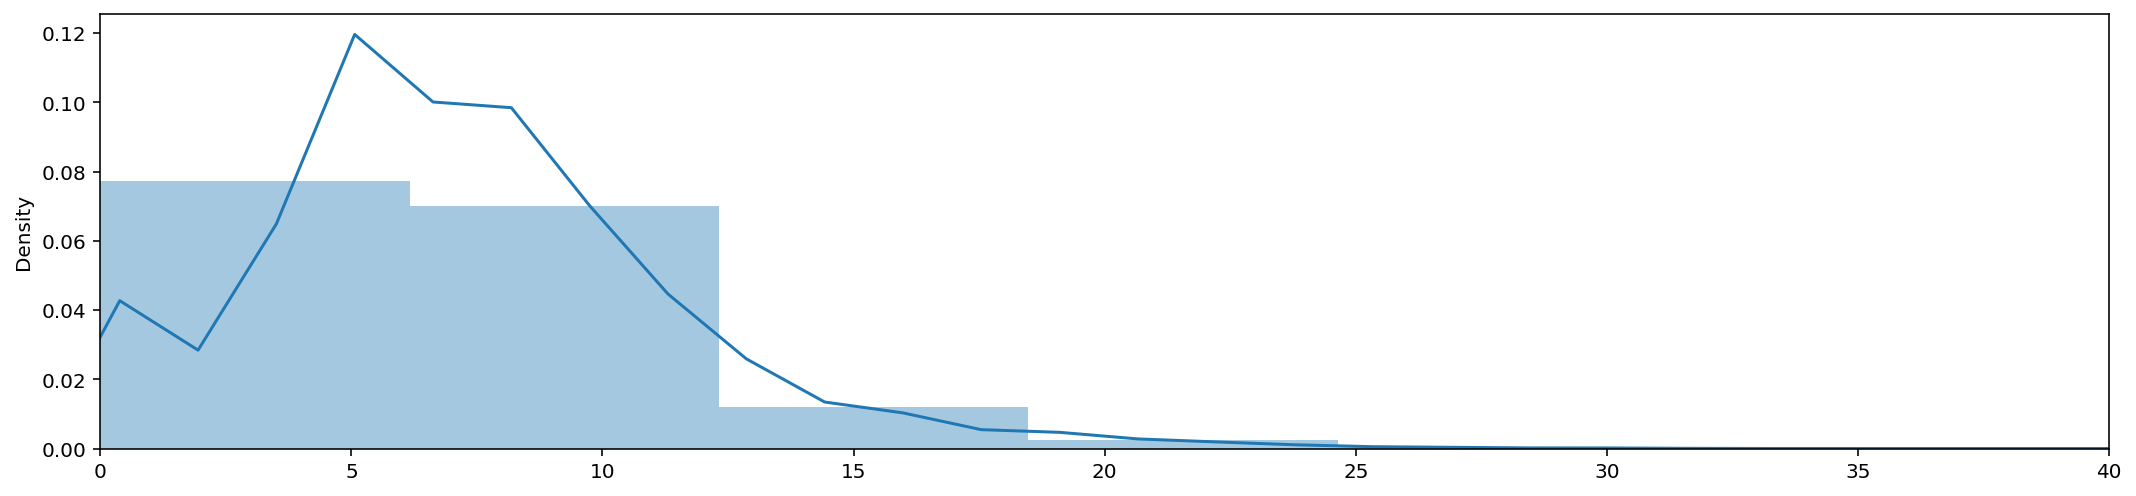

In [ ]:
############################## 1차 문장 필터링 문장내 단어의 갯수 파악 : 단어는 공백기준으로 판단 ##############################
# 문장의 단어갯수가 2개 미만이면 삭제처리? 
# 문장들의 단어갯수 분포 히스토그램을 보면 대부분 몇글자로 이루어져있는지 알 수 있음
words_count = [len(row.split()) for row in raw_corpus if " " not in row.split() ]



# 전체 문장의 단어갯수 중에서 제일 작은 단어갯수 
print("min words per sentence: ", min(words_count) ) 
print("max words per sentence: ", max(words_count) ) 
# 시각화
plt.figure(figsize=(18,4))
plt.xlim([0, 40])
sns.distplot(words_count)
plt.show()


In [ ]:
words_count_0 = [sentence for sentence in raw_corpus if len(sentence.split()) == 0 ]
words_count_1 = [sentence for sentence in raw_corpus if len(sentence.split()) == 1 ]
words_count_over40 = [sentence for sentence in raw_corpus if len(sentence.split()) > 40 ]


print("{:=^75}".format(" [단어 갯수가 0 인 문장] "))
print("* 단어갯수가 0인 문장 갯수: ",len(words_count_0))
print("* 전체문장수 대비 단어갯수가 0인 문장 갯수 비율: ",len(words_count_0)/len(raw_corpus))
print("* 단어갯수가 0인 문장 일부 확인 \n",words_count_0[10:15])
print("* 단어갯수가 0인 문장 중복제거 \n",list(dict.fromkeys(words_count_0) ))


print("\n {:=^75}".format(" [단어 갯수가 1 인 문장] "))
print("* 단어갯수가 1인 문장 갯수: ",len(words_count_1))
print("* 전체문장수 대비 단어갯수가 1인 문장 갯수 비율: ",len(words_count_1)/len(raw_corpus))
print("* 단어갯수가 1인 문장 일부 확인 \n",words_count_1[10:15])
print("* 단어갯수가 1인 문장 중복제거 \n",list(dict.fromkeys(words_count_1) ))



print("\n {:=^75}".format(" [단어 갯수가 40개 초과인 문장] "))
print("* 단어갯수가 40개 초과인 문장 갯수: ",len(words_count_over40))
print("* 전체문장수 대비 단어갯수가 40개 초과인 문장 갯수 비율: ",len(words_count_over40)/len(raw_corpus))
print("* 단어갯수가 40개 초과인 문장 일부 확인 \n",words_count_over40[10:15])
print("* 단어갯수가 40개 초과인 문장 중복제거 \n",list(dict.fromkeys(words_count_over40) ))


============================= [단어 갯수가 0 인 문장] =============================
* 단어갯수가 0인 문장 갯수:  11128
* 전체문장수 대비 단어갯수가 0인 문장 갯수 비율:  0.05948003078765073
* 단어갯수가 0인 문장 일부 확인 
 ['', '', '', '', '']
* 단어갯수가 0인 문장 중복제거 
 ['', ' ', '  ']

 ============================= [단어 갯수가 1 인 문장] =============================
* 단어갯수가 1인 문장 갯수:  3500
* 전체문장수 대비 단어갯수가 1인 문장 갯수 비율:  0.01870777388180963
* 단어갯수가 1인 문장 일부 확인 
 ['Belle,', 'Belle,', 'Belle,', 'Ooh', 'I,']
* 단어갯수가 1인 문장 중복제거 
 ['Oh', 'Baby', 'Belle,', 'Belle', 'Ooh', 'I,', 'Beautiful', 'Hey', 'Yeah', 'Beauti,', 'Flying', 'Darling', 'Sacrificed', 'Wo-oh-oh-oh-oh-oh', 'Oh-oh-oh-oh-oh-oh', '(Yeah...yeah...)', '(Ho...)', '(La-la-la-la-la-la-la-la-la)', 'No', 'Nah', '(Unbreakable)', 'Kandi', 'Higher', 'Black', 'Valerie', 'innit', 'Cant', 'Ah', 'Quiet', 'Sweetest', 'Depleted', 'Hustle...', 'Always', 'A-a-a-antisocial', 'A-a-a', 'Tonight', 'Again', 'Whoa', 'Suggests', 'Touches', 'Arousal', 'Emergency', 'Sometimes', 'babe', 'Crooked', 'Kahiiiiiii', 'Kah


위에서 본 데이터의 문장 일부를 출력해보니 특수문자가 들어가있는 문장들이 존재한다. 또한 공백으로만 이루어져있거나, 단어하나로만 이루어진 문장들이 존재하는것을 확인 할 수 있다. 이러한 요소는 앞으로 진행할 데이터 토큰화 과정에서 약간의 문제로 작용할 수 있기에 불필요한문자들을 제거하는 전처리과정을 진행하기로 한다.

## **2. 데이터 전처리**

### **2-1. 정제(Cleaning) and 정규화(Normalization)**

코퍼스에서 용도에 맞게 토큰을 분류하는 작업을 토큰화(tokenization)라고 하며, 토큰화 작업 전, 후에는 텍스트 데이터를 용도에 맞게 정제(cleaning) 및 정규화(normalization)하는 일이 항상 함께한다. 정제 및 정규화의 목적은 각각 다음과 같다.

- 정제(cleaning) : 갖고 있는 코퍼스로부터 노이즈 데이터를 제거한다.
- 정규화(normalization) : 표현 방법이 다른 단어들을 통합시켜서 같은 단어로 만들어준다.   

정제 작업은 토큰화 작업에 방해가 되는 부분들을 배제시키고 토큰화 작업을 수행하기 위해서 토큰화 작업보다 앞서 이루어지기도 하지만, 토큰화 작업 이후에도 여전히 남아있는 노이즈들을 제거하기위해 지속적으로 이루어지기도 합니다. 사실 완벽한 정제 작업은 어려운 편이라서, 대부분의 경우 이 정도면 됐다.라는 일종의 합의점을 찾기도 합니다.



### **2-1. 정규표현식을 활용한 불필요한 문자 필터링**

In [ ]:
##############################  공백,특수문자,문장부호,대소문자 정제하는 함수 정의  ##############################

# 1. 소문자로 바꾸고, 양쪽 공백을 지운다
# 2. 특수문자 양쪽에 공백을 넣고
# 3. 여러개의 공백은 하나의 공백으로 바꾼다
# 4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾼다
# 5. 다시 양쪽 공백을 지운다
# 6. 문장 시작에는 <start>, 끝에는 <end>를 추가한다

def preprocess_sentence(sentence):
  if sentence[-1] == ":" : sentence = ""
  sentence = sentence.lower().strip() # 1
  sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
  sentence = re.sub(r'[" "]+', " ", sentence) # 3
  sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
  sentence = sentence.strip() # 5
  sentence = '<start> ' + sentence + ' <end>' # 6
  return sentence 

In [ ]:
##############################  정제데이터 구축  ##############################
corpus = [preprocess_sentence(sentence) for sentence in raw_corpus if len(sentence) != 0 ]
corpus[:30]

['<start> let s stay together i , i m i m so in love with you <end>',
 '<start> whatever you want to do <end>',
 '<start> is all right with me <end>',
 '<start> cause you make me feel so brand new <end>',
 '<start> and i want to spend my life with you let me say that since , baby , since we ve been together <end>',
 '<start> loving you forever <end>',
 '<start> is what i need <end>',
 '<start> let me , be the one you come running to <end>',
 '<start> i ll never be untrue oh baby <end>',
 '<start> let s , let s stay together gether <end>',
 '<start> lovin you whether , whether <end>',
 '<start> times are good or bad , happy or sad <end>',
 '<start> oh , oh , oh , oh , yeah <end>',
 '<start> whether times are good or bad , happy or sad why , why some people break up <end>',
 '<start> then turn around and make up <end>',
 '<start> i just can t see <end>',
 '<start> you d never do that to me would you , baby <end>',
 '<start> staying around you is all i see <end>',
 '<start> here s what i 

### **2-2. 데이터 토큰화 & 텐서 변환**

In [ ]:
##############################  데이터 토큰화를 위한 함수 정의  ############################## 

# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 12,000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 12,000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    # 토큰화 했을 때 토큰의 개수가 20개를 넘어가는 문장을 학습 데이터에서 제외하기 
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=20)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer


In [ ]:
##############################  토큰화된 텐서 데이터 생성 및 출력  ############################## 
tensor, tokenizer = tokenize(corpus)
print(tensor[:3, :10]) #생성된 텐서 데이터를 3번째 행, 10번째 열까지만 출력해 봅시다.

[[   2   63   16 ...    0    0    0]
 [   2  598    7 ...    0    0    0]
 [   2   26   24 ...    0    0    0]
 ...
 [   2  211    3 ...    0    0    0]
 [   2  400    9 ...    0    0    0]
 [   2    9 1296 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f1a28265290>
[[  2  63  16 222 283   5   4   5  22   5]
 [  2 598   7  62  10  47   3   0   0   0]
 [  2  26  24  84  31  12   3   0   0   0]]


In [ ]:
##############################  tokenizer에 구축된 단어 사전 확인  ############################## 

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [ ]:
##############################  텐서를 소스와 타겟으로 분리  ############################## 

# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2  63  16 222 283   5   4   5  22   5  22  30  14  33  31   7   3   0
   0]
[ 63  16 222 283   5   4   5  22   5  22  30  14  33  31   7   3   0   0
   0]


### **2-3. 데이터셋(tf.data.Dataset) 객체 생성**

In [ ]:
################### 학습, 테스트 데이터 나누기  ###############
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=121)



print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (140788, 19)
Target Train:  (140788, 19)


In [ ]:
##############################  tf.data.Dataset.from_tensor_slices() : tf.data.Dataset객체를 생성  ############################## 

BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
# steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 19), dtype=tf.int32, name=None), TensorSpec(shape=(256, 19), dtype=tf.int32, name=None))>

## **3. 모델 구현 및 평가**
---

### **3-1. 모델 생성**

In [ ]:
##############################  모델구조  ############################## 


class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        # representation: 의미 벡터 공간에서 단어의 추상적 표현으로 사용되도록 
            # 입력텐서의 단어사전 인덱스값을 해당 인덱스번째의 워드 벡터로 밤꿔줌 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)

    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out




embedding_size = 20 
hidden_size = 2000 


model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

### **3-2. 모델 학습**


#### **3-2-1. 모델 구조 확인**


In [ ]:
##############################  모델구조 확인을 위해 하나의 배치만 가지고오기  ############################## 

for src_sample, tgt_sample in dataset.take(1): break

model(src_sample) # 한 배치만 불러온 데이터를 모델에 넣어봄

<tf.Tensor: shape=(256, 19, 12001), dtype=float32, numpy=
array([[[-1.67036637e-06,  2.37896347e-06, -2.94493420e-05, ...,
          4.08373126e-05,  1.57522427e-05, -2.84374109e-05],
        [ 2.03639520e-05, -4.18423515e-05, -1.36453935e-04, ...,
          7.67088659e-06, -7.93689469e-06, -9.01278472e-05],
        [-2.70104720e-05, -4.12160989e-05, -2.18690038e-04, ...,
         -3.33810603e-05, -2.11230545e-05, -1.42800593e-04],
        ...,
        [ 2.00014274e-05, -5.09017962e-04,  2.60916160e-04, ...,
          2.86882569e-04, -2.76135514e-04,  1.18806413e-04],
        [-2.22591152e-05, -6.05480105e-04,  2.08397847e-04, ...,
          3.02605506e-04, -3.39197082e-04,  1.48113395e-04],
        [-6.37937483e-05, -6.92480942e-04,  1.64300320e-04, ...,
          3.06288683e-04, -3.94686213e-04,  1.79276380e-04]],

       [[-1.67036637e-06,  2.37896347e-06, -2.94493420e-05, ...,
          4.08373126e-05,  1.57522427e-05, -2.84374109e-05],
        [ 2.53311664e-05,  1.23425139e-04, -5

In [ ]:
model.summary()

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  240020    
                                                                 
 lstm (LSTM)                 multiple                  16168000  
                                                                 
 lstm_1 (LSTM)               multiple                  32008000  
                                                                 
 dense (Dense)               multiple                  24014001  
                                                                 
Total params: 72,430,021
Trainable params: 72,430,021
Non-trainable params: 0
_________________________________________________________________


#### **3-2-2. 모델 학습**


In [ ]:
###################### 
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
optimizer = tf.keras.optimizers.Adam()
# tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)
epochs = 10


model.compile(loss=loss, optimizer=optimizer)
history = model.fit(enc_train, 
          dec_train, 
          epochs=epochs,
          batch_size=256,
          validation_data=(enc_val, dec_val), 
          verbose=1)


Epoch 1/10
550/550 [==============================] - 182s 323ms/step - loss: 3.0898 - val_loss: 2.6975
Epoch 2/10
550/550 [==============================] - 177s 321ms/step - loss: 2.5709 - val_loss: 2.4839
Epoch 3/10
550/550 [==============================] - 177s 321ms/step - loss: 2.3928 - val_loss: 2.3722
Epoch 4/10
550/550 [==============================] - 177s 321ms/step - loss: 2.2534 - val_loss: 2.2884
Epoch 5/10
550/550 [==============================] - 177s 321ms/step - loss: 2.1196 - val_loss: 2.2091
Epoch 6/10
550/550 [==============================] - 177s 321ms/step - loss: 1.9816 - val_loss: 2.1451
Epoch 7/10
550/550 [==============================] - 176s 320ms/step - loss: 1.8402 - val_loss: 2.0823
Epoch 8/10
550/550 [==============================] - 176s 320ms/step - loss: 1.6980 - val_loss: 2.0346
Epoch 9/10
550/550 [==============================] - 176s 321ms/step - loss: 1.5576 - val_loss: 1.9944
Epoch 10/10
550/550 [==============================] - 177s 321m

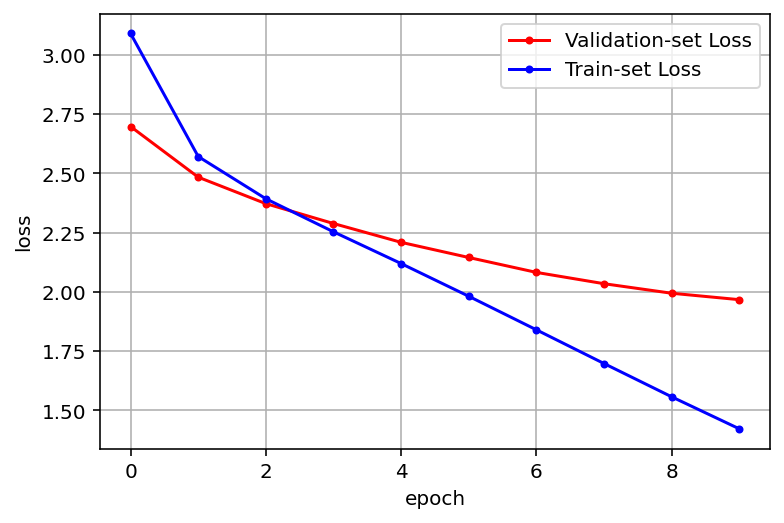

In [ ]:

 #################### epoch 별 loss 시각화 #################################################
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### **3-3. 모델 평가**


In [ ]:

##############################  작문수행하는 함수 정의  ############################## 
# 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문

def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [ ]:
##############################  작문수행 함수 실행  ############################## 
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m not gonna crack <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> i am", max_len=20)

'<start> i am not throwing away my shot <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> your love", max_len=20)

'<start> your love is fadin <end> '